# Data Description

## Overview
The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.
The scope of this notebook is not to build a great ML model, but to perform a informative Exploratory Data Analysis.
In any case I think I'll perform some traditional classification model and some ensemble. 

The test set should be used to see how well your model performs on unseen data. I won't perform an EDA on it, but I will adapt it's structure based on the training dataset. For the test set, Kaggle do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

If you are interested in Kaggle competitions, it is included gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

## Data Dictionary
|Variable|	Definition|	Key|
|---|---|---|
|survival|	Survival|	0 = No, 1 = Yes|
|pclass	|Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd!
|sex|	Sex	||
|Age|	Age in years	||
|sibsp|	# of siblings / spouses aboard the Titanic||	
|parch|	# of parents / children aboard the Titanic||	
|ticket|	Ticket number|	|
|fare|	Passenger fare	||
|cabin|	Cabin number	||
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

## Variable Notes
**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
# Import packages
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
# Importing training and test sets
train = pd.read_csv("datasets/titanic/train.csv")
test = pd.read_csv("datasets/titanic/test.csv")

# 1 - Data Cleaning

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I think that:
- `PassengerId` doesn't carry any useful information. But before deleting it
I want to check if it is equal to the index plus 1
- `Survived` is the target variable. I will shift it at the end of the dataset
- `Pclass` is an important predictor
- `Name` can be useful because we can see person's title (Mr., Miss., etc.).
- `Sex` can be an informative variable. I don't know how priority worked at that time,
but maybe females had the precedence to go on a lifeboat
- `Age` can be a good discriminating between surviving or not
- `SibSp` and `Parch` can be useful too. I think that lonely men didn't have
much chance to go on a lifeboat. Summing them to form a column maybe could be a good idea.
- `Ticket` is not informative like `PassengerId`
- `Fare` could bring the same information of the class of the passenger. Maybe we
could see if there is a significant difference in the ticket price even in the same class.
In this case we can create a new class column
- `Cabin`: same considerations as `PassengerId` and `Ticket` 
- `Embarked` I don't think can influence the survival rate. We'll see

### Useless columns: `PassengerID`, `Ticket` and `Cabin` 

In [5]:
(train['PassengerId'] == (train.index + 1)).value_counts()

True    891
dtype: int64

These columns bring no information to us. I delete them:

In [6]:
train = train.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
test = test.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)

Let's see train and test shape:

In [7]:
print(" Train shape: {0}".format(train.shape),"\n", "Test shape: {0}".format(test.shape),
      "\n","Train / Train + Test rows: {0}".format(train.shape[0]/(train.shape[0]+test.shape[0])))

 Train shape: (891, 9) 
 Test shape: (418, 8) 
 Train / Train + Test rows: 0.680672268907563


There are 8 predictors and the rows proportion between train and test set is good.
Let's see some generical info and description of the training set:

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [9]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that:
- about 38% of passengers survived
- Age average was about 30 years old
- there were no (or a few) big families
- the average ticket price was about 32 pound. But it has a very high standar deviation, it means that 
3rd class tickets were a lot cheaper than 1st class tickets. 
- Age column has almost 200 missing values and embarked only 2. Other columns have no NAs.

In [10]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

After An exploration, I think that will be ok to fill Age NAs with the mean and Embarked NAs
with the mode.

# 2 - Exploratory Data Analysis

First of all, we can see how the response variable and other features relationships.

## Survived - Pclass relationship

In [11]:
pd.crosstab(train['Pclass'], train['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


From the contingency table we can deduce that there is a strong correlation between
these features. The difference between 1st and 3rd class survival rate is huge.

## Survived - Sex

In [12]:
pd.crosstab(train['Sex'], train['Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Also here the correlation is strong. If you were a man on the Titanic, it's very likely that you died.
I'm curious to see at which class belonged survived men:

In [13]:
pd.pivot_table(data=train, index=['Sex', 'Pclass'], values='Survived')

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

So if you were a female in the first and second class you probably survived.
If you were a man in the 1st one you had a chance.

## Survived - Age

<AxesSubplot:xlabel='Survived', ylabel='Age'>

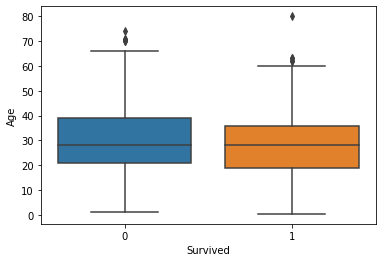

In [14]:
sns.boxplot(x='Survived', y='Age', data=train)

From the boxplot I deduce that Age wasn't a discriminant between live or death.
Survived people were slightly younger than the others, but the difference is very
small. If a big percentage of the youngest and oldest survived, I'll fill Age
NAs with the mean and I'll create a new categorical variable to train the model.
Otherwise I'll delete it.  

In [15]:
print(" If you were over 55, your probability to survive was about", "{:.0%}.".format(train.loc[train['Age'] > 60 ,'Survived'].mean()),
"\n", "And if you were under 10 it was about", "{:.0%}.".format(train.loc[train['Age'] < 10 ,'Survived'].mean()))

 If you were over 55, your probability to survive was about 23%. 
 And if you were under 10 it was about 61%.


Given these results, maybe it will be usefull to create a factorial variable on age to train the model.

## Survived - SibSp

<AxesSubplot:xlabel='Survived', ylabel='SibSp'>

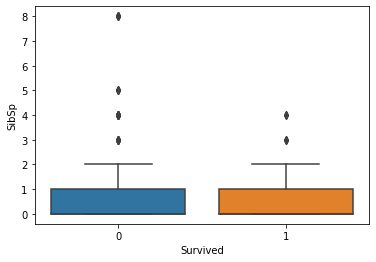

In [16]:
sns.boxplot(x='Survived', y='SibSp', data=train)

Most of the observation have a `SibSp` value equal to zero. This feature doesn't
carry with it much variance. We can survival rate for persons who have no siblings/spouse
aboard the Titanic.

In [17]:
train.loc[train['SibSp'] == 0, 'Survived'].value_counts()

0    398
1    210
Name: Survived, dtype: int64

Almost two-thirds of them died. It's not much higher than general survival rate
of about 38%, but maybe a dummy variable can be useful for the model. 

## Survived - Parch

<AxesSubplot:xlabel='Survived', ylabel='Parch'>

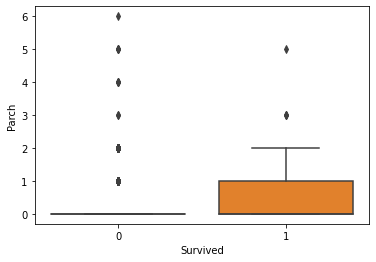

In [18]:
sns.boxplot(x='Survived', y='Parch', data=train)

The relationship between `Survived` and `Parch` variables is similar to the previous one,
but amplified.

In [19]:
train.loc[train['Parch'] == 0, 'Survived'].value_counts()

0    445
1    233
Name: Survived, dtype: int64

And if wee see the frequency for lonely passengers?

In [20]:
train.loc[(train['SibSp'] == 0) & (train['Parch'] == 0), 'Survived'].value_counts()

0    374
1    163
Name: Survived, dtype: int64

Survival rate for lonely passengers drops to about 30%. 
In the feature engineering section I will create a dummy variable to explain
if a person was abroad alone or not.

## Survived - Embarked

In [21]:
pd.crosstab(train['Embarked'], train['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


I didn't expect to find differences in survival rate through ports of embarkation.
is this related to the class? Or to the are of the Titanic where they come aboard?
Is this a coincidence?

In [22]:
pd.pivot_table(data=train, index=['Embarked','Pclass'],values='Survived', aggfunc='count')

Survived
Embarked Pclass          
C        1             85
         2             17
         3             66
Q        1              2
         2              3
         3             72
S        1            127
         2            164
         3            353

As we expected the apparent influence of port of embarkation on survival rate is
due to the class of belonging of the passenger.
I delete it.

In [23]:
train = train.drop(['Embarked'], axis=1)
test = test.drop(['Embarked'], axis=1)

## Survived - Name
We want to analyze if `Name` feature can be engineered to extract a correlation
between titles and survival rate.
If we won't find a correlation, we simply drop the column.

In [24]:
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [25]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [26]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [27]:
pd.pivot_table(data=train, index='Title', values='Survived')

,Survived
Title,
Capt,0.000000
Col,0.500000
Countess,1.000000
Don,0.000000
Dr,0.428571
Jonkheer,0.000000
Lady,1.000000
Major,0.500000
Master,0.575000


Seeing last pivot table and crosstab, I don't see any additional information
with respect to what given by `Sex` column. 

In [28]:
train = train.drop(columns=['Name', 'Title'])
test = test.drop(columns=['Name', 'Title'])

## Correlation between numerical variables

<AxesSubplot:>

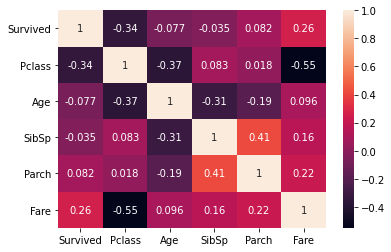

In [29]:
cor = train.select_dtypes(exclude='object').corr(method='pearson')
sns.heatmap(cor, annot=True)

There is no high correlation between predictors, we can keep them all to train a model.
Maybe we can drop `Fare` column, we'll see.

# 3 - Data preparation and Feature Engineering

## NAs
Given observations on `Age` in the previous section, I'll fill NAs with the mean
and I will create a clustered age column.

In [30]:
print(" Train NAs: ","\n","{0}".format(train.isna().sum()),"\n",
     "Test NAs: ","\n","{0}".format(test.isna().sum()))

 Train NAs:  
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64 
 Test NAs:  
 Pclass     0
Sex        0
Age       86
SibSp      0
Parch      0
Fare       1
dtype: int64


In test set also one ticket price has a missing value, I'll fill it with class
average price but I don't think this will be usefull to classify the target column.

In [31]:
test.loc[test['Fare'].isna(), 'Pclass']

152    3
Name: Pclass, dtype: int64

The class of the passenger whose ticket price is missing is the third.

In [32]:
test.loc[test['Pclass'] == 3, 'Fare'].mean()

12.459677880184334

In [33]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)
test['Fare'].fillna(test.loc[test['Pclass'] == 3, 'Fare'].mean(), inplace=True)

## Age

In [34]:
bins = [0, 9, 55, 90]
labels = ['kid', 'adult', 'old']
train['age_group'] = pd.cut(train['Age'], bins=bins,
                            labels=labels)
pd.pivot_table(data=train, index='age_group', values='Age', aggfunc=[np.min, np.max])

,amin,amax
,Age,Age
age_group,,
kid,0.42,9.0
adult,10.00,55.0
old,55.50,80.0


Age is grouped as we wanted. Let's do the same for test set.

In [35]:
test['age_group'] = pd.cut(test['Age'], bins=bins,
                            labels=labels)

## SibSp + Parch -> Alone or not

In [36]:
train['SibSp+Parch'] = train['SibSp'] + train['Parch']
test['SibSp+Parch'] = test['SibSp'] + test['Parch']

In [37]:
# Alone = 1 if the passenger is alone, 0 if he/she is not
train['Alone'] = np.where(train['SibSp+Parch'] == 0, 1, 0)
test['Alone'] = np.where(test['SibSp+Parch'] == 0, 1, 0)

## Sex -> Dummy

In [38]:
# If the passenger is a female -> 1, otherwise -> 0
train['sex_dummy'] = np.where(train['Sex'] == 'female', 1, 0)
test['sex_dummy'] = np.where(test['Sex'] == 'female', 1, 0)

## One-hot-encoding of `age_group` 

In [39]:
one_hot = pd.get_dummies(train['age_group']).iloc[:,0:2]
train = train.drop('age_group', axis=1)
train = train.join(one_hot)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,SibSp+Parch,Alone,sex_dummy,kid,adult
0,0,3,male,22.0,1,0,7.2500,1,0,0,0,1
1,1,1,female,38.0,1,0,71.2833,1,0,1,0,1
2,1,3,female,26.0,0,0,7.9250,0,1,1,0,1
3,1,1,female,35.0,1,0,53.1000,1,0,1,0,1
4,0,3,male,35.0,0,0,8.0500,0,1,0,0,1


In [40]:
one_hot = pd.get_dummies(test['age_group']).iloc[:,0:2]
test = test.drop('age_group', axis=1)
test = test.join(one_hot)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,SibSp+Parch,Alone,sex_dummy,kid,adult
0,3,male,34.5,0,0,7.8292,0,1,0,0,1
1,3,female,47.0,1,0,7.0000,1,0,1,0,1
2,2,male,62.0,0,0,9.6875,0,1,0,0,0
3,3,male,27.0,0,0,8.6625,0,1,0,0,1
4,3,female,22.0,1,1,12.2875,2,0,1,0,1


# 4 - Training and evaluating a model 

Our scope is to classify if a Titanic passenger survived or not.
We can do this by training a classification model.
The Python library that helps us to train a Machine Learning model is Scikit-Learn.
I will certainly use:
- Naive-Bayes classifier
- Logistic Regression
- k-Nearest Neighbors
- Support Vector Machine
- Decision Tree
- Random forest

I will perform a simple train-test split, while the reader can perform a k-Cross Validation.
I can't use `test.csv` like a validation set because I don't know real values
of the response variable.

N.B.: Scikit-learn is a great library, but if you want to see in depth model structures
and the relationship between predictors and class column you could use `statsmodels` package.

Let's keep only columns we think that will be useful to train the model. 

In [41]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'SibSp+Parch', 'Alone', 'sex_dummy', 'kid', 'adult'],
      dtype='object')

In [42]:
test.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SibSp+Parch',
       'Alone', 'sex_dummy', 'kid', 'adult'],
      dtype='object')

In [49]:
drop_columns = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare','SibSp+Parch']
train_model = train.drop(drop_columns, axis=1)
test_model = test.drop(drop_columns, axis=1)

Splitting train in training and test set:

In [50]:
from sklearn.model_selection import train_test_split

predictors = train_model.iloc[:, 1:]
Class = train_model['Survived']
X_train, X_test, y_train, y_test = train_test_split(
        predictors, Class, test_size= 0.25, random_state=123)

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((668, 5), (668,), (223, 5), (223,))

## Naive-Bayes classifier

In [79]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, y_test), 3)
acc_gaussian

0.776

## Logistic Regression

In [62]:
# importing the module needed to perform a logistic regression
from sklearn.linear_model import LogisticRegression

r_log = LogisticRegression(random_state=123)
r_log.fit(X_train, y_train)
y_pred = r_log.predict(X_test)
acc_log = round(sum(y_pred == y_test)/len(y_test), 3)
acc_log

0.789

In [55]:
r_log_coeff = pd.DataFrame({'Feature': X_train.columns, 
                            'Coefficient': r_log.coef_[0]}
                          )
r_log_coeff

,Feature,Coefficient
0,Pclass,-0.983690
1,Alone,0.121722
2,sex_dummy,2.548131
3,kid,1.824704
4,adult,0.493743


As we can see:
- `Pclass` has a negative coeffincient, in fact the higher is the class the lower
is the survival rate
- `Alone` coefficient is slightly positive. This make me think that the model
didn't capture the relationship with the response variable in the right way (earlier
we saw that lonely people had a lower survival rate on data).
- `Sex` column coefficient is positive, in fact if you were a female you had a better
chance of surviving.
- As we have seen earlier if you were under 10 you problably survived (high positive coefficient),
and the more you grew on age the lower chance of surviving you had.

The reader can dive deeper in this considerations and try to figure out better predictors.

## k-Nearest Neighbors

In [76]:
# importing the module needed
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.predict(X_test)
acc_knn = round(knn.score(X_test, y_test), 2)
acc_knn

0.82

## Support Vector Machine

In [70]:
# importing the module needed
from sklearn.svm import SVC

svc = SVC(random_state=123)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
acc_svc = round(sum(svc_pred == y_test)/len(svc_pred), 3)
acc_svc

0.794

## Decision Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=123)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
acc_tree = round(tree.score(X_test, y_test), 3)
acc_tree

0.843

## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, criterion='gini',
                                       random_state=123)
random_forest.fit(X_train, y_train)
forest_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_test, y_test), 3)
acc_random_forest

0.834

## Model selection
We can now rank our evaluation of all the models to choose the best one for our problem.

In [86]:
models = pd.DataFrame({
    'Model': ['Naive-Bayes classifier',
              'Logistic Regression',
              'k-Nearest Neighbors',
              'Support Vector Machine',
              'Decision Tree',
              'Random forest'],
    'Accuracy': [acc_gaussian, acc_log, acc_knn, acc_svc,
                 acc_tree, acc_random_forest]
})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Decision Tree,0.843
5,Random forest,0.834
2,k-Nearest Neighbors,0.820
3,Support Vector Machine,0.794
1,Logistic Regression,0.789
0,Naive-Bayes classifier,0.776


Decision Tree has the best performance, it predicted 84.3% of test observations correctly.
Random Forest had a slightly lower performance, but it is usualy more stable than decision trees,
which often suffer of high variance. Furthermore I think that tuning the parameters
it can overtake the Decision Tree accuracy.

The reader can perform a cross validation and compete in [Kaggle](https://www.kaggle.com) competition!

# References

- [Kaggle: Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
- [Kaggle: Titanic - Data Science solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)